In [1]:
# Necessary libraries

import os
os.chdir('..')

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

from src.swbm import *
from src.plots import *
from src.utils import *

np.random.seed(42)

In [2]:
# Load data
input_swbm_raw = pd.read_csv('data/Data_swbm_Germany.csv')
input_swbm = prepro(input_swbm_raw)

# Constant SWBM Parameters

In [4]:
# ---- Constant model

const_swbm_params = {'c_s': 420, 'b0': 0.8, 'g': .5, 'a': 4}

# Run SWBM without seasonal variation
moists, runoffs, ets, _ = predict_ts(input_swbm, const_swbm_params)
eval_df = eval_swbm(input_swbm,
                    {'sm': moists, 'ro': runoffs, 'le': ets},
                    'None\nSeasonal')
eval_df

,parameter,kind,corr,pval
0,None\nSeasonal,sm,0.878382,0.000000e+00
1,None\nSeasonal,ro,0.483657,1.077349e-234
2,None\nSeasonal,le,-0.592983,0.000000e+00


# Seasonal variation of single parameters 

In [5]:
# ---- Seasonal Variation for single parameter
param_opt_sin_init = {'b0': [0.5, 2, 5, 0.8],
                      'g': [0.1, 2, 5, 0.5],
                      'a': [1, 2, 5, 4]}

single_preds = {'b0': {}, 'g': {}, 'a': {}}
opt_params_dfs = {'b0': {}, 'g': {}, 'a': {}}

for swbm_param, init_values in param_opt_sin_init.items():
    np.random.seed(42)
    const_swbm_params = {'c_s': 420, 'b0': 0.8, 'g': .5, 'a': 4}
    res = minimize(opt_swbm_corr,
                   np.asarray(init_values).flatten(),  # has to be 1D
                   args=(input_swbm, const_swbm_params, swbm_param),
                   options={"maxiter": 500, "disp": True})
    opt_params_df = minimize_res2df(res, [swbm_param])

    # Set swbm const_swbm_params
    params_seasonal = {'c_s': 420, 'b0': 0.8, 'g': .5, 'a': 4}
    # Get sinus curve for current single parameter
    params_seasonal[swbm_param] = seasonal_sinus(
        len(input_swbm),
        amplitude=opt_params_df.loc['amplitude', swbm_param],
        freq=opt_params_df.loc['freq', swbm_param],
        phase=opt_params_df.loc['phase', swbm_param],
        center=opt_params_df.loc['center', swbm_param],
        which=swbm_param
    )

    # Run SWBM
    preds_seasonal = predict_ts(input_swbm, params_seasonal)
    moists_seasonal, runoffs_seasonal, ets_seasonal, _ = preds_seasonal

    single_preds[swbm_param]['sm'] = moists_seasonal
    single_preds[swbm_param]['ro'] = runoffs_seasonal
    single_preds[swbm_param]['le'] = ets_seasonal

    for param in ['amplitude', 'freq', 'phase', 'center']:
        opt_params_dfs[swbm_param][param] = opt_params_df.loc[param, swbm_param]

    # Test correlation
    eval_df = pd.concat((eval_df, eval_swbm(input_swbm,
                                            single_preds[swbm_param],
                                            swbm_param)))

Optimization terminated successfully.
         Current function value: -0.893547
         Iterations: 16
         Function evaluations: 100
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: -0.892720
         Iterations: 39
         Function evaluations: 225
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: -0.527787
         Iterations: 33
         Function evaluations: 215
         Gradient evaluations: 43


In [6]:
eval_df.pivot(index='parameter', columns='kind', values='corr').sort_values(by='sm', ascending=False)

kind,le,ro,sm
parameter,,,
b0,0.910346,0.463527,0.893547
g,-0.110674,0.450739,0.892720
None\nSeasonal,-0.592983,0.483657,0.878382
a,-0.531490,0.527787,0.837895


# Importance of parameters to be seaonal

### Optimize all SWBM parameters to be seasonal

In [7]:
# ---- Optimize all

# initialize parameters and sinus const_swbm_params
init_sinus_params_all = [[0.5, 2, 5, 420],
                         # c_s (amplitude, freq, phase, center)
                         [0.5, 2, 5, 0.8],  # b0 -> max. ET
                         [0.1, 2, 5, 0.5],  # g -> ET function shape
                         [1, 2, 5, 4]]  # a -> runoff function shape
make_seasonal_all = ['c_s', 'b0', 'g', 'a']

# optimize sinus parameters
np.random.seed(42)
res_all = minimize(opt_swbm_corr,
                   np.asarray(init_sinus_params_all).flatten(),  # has to be 1D
                   args=(input_swbm, {}, make_seasonal_all),
                   options={"maxiter": 500, "disp": True})
# extract optimized sinus parameters
opt_params_all_df = minimize_res2df(res_all, make_seasonal_all)

# get optimized seasonal parameters
opt_sinus_all = {}
for swbm_param in opt_params_all_df:
    opt_sinus_all[swbm_param] = seasonal_sinus(
        len(input_swbm),
        amplitude=opt_params_all_df.loc['amplitude', swbm_param],
        freq=opt_params_all_df.loc['freq', swbm_param],
        phase=opt_params_all_df.loc['phase', swbm_param],
        center=opt_params_all_df.loc['center', swbm_param],
        which=swbm_param
    )

# Run SWBM
preds_all = predict_ts(input_swbm, opt_sinus_all)
preds_seasonal_all = {'sm': preds_all[0],
                      'ro': preds_all[1],  # messed up sinus phase here
                      'le': preds_all[2]}
# get correlations
eval_df = pd.concat((eval_df, eval_swbm(input_swbm, preds_seasonal_all, 'all')))

Optimization terminated successfully.
         Current function value: -0.936783
         Iterations: 232
         Function evaluations: 5746
         Gradient evaluations: 338


In [8]:
eval_df.pivot(index='parameter', columns='kind', values='corr').sort_values(by='sm', ascending=False)

kind,le,ro,sm
parameter,,,
all,0.878091,0.309907,0.936783
b0,0.910346,0.463527,0.893547
g,-0.110674,0.450739,0.892720
None\nSeasonal,-0.592983,0.483657,0.878382
a,-0.531490,0.527787,0.837895


### Leaf one out for optimization

In [9]:
# ---- Optimize all except for one parameter

init_sinus_params_all = np.asarray(init_sinus_params_all)
for i, swbm_param in enumerate(make_seasonal_all):
    const_swbm_params = {'c_s': 420, 'b0': 0.8, 'g': .5, 'a': 4}
    # optimize sinus parameters
    np.random.seed(42)
    # exclude current param. from init values and list of params
    make_seasonal_tmp = [p for p in make_seasonal_all if p != swbm_param]
    init_sinus_params_tmp = np.delete(init_sinus_params_all, i, axis=0)
    res_tmp = minimize(opt_swbm_corr,
                       init_sinus_params_tmp.flatten(),
                       # has to be 1D
                       args=(input_swbm, const_swbm_params, make_seasonal_tmp),
                       options={"maxiter": 500, "disp": True})
    # extract optimized sinus parameters
    opt_params_df = minimize_res2df(res_tmp, make_seasonal_tmp)

    # get optimized seasonal parameters
    opt_sinus = {'c_s': 420, 'b0': 0.8, 'g': .5, 'a': 4}
    for p in opt_params_df:
        opt_sinus[p] = seasonal_sinus(
            len(input_swbm),
            amplitude=opt_params_df.loc['amplitude', p],
            freq=opt_params_df.loc['freq', p],
            phase=opt_params_df.loc['phase', p],
            center=opt_params_df.loc['center', p],
            which=p
        )

    # Run SWBM
    model_sm, model_ro, model_le, _ = predict_ts(input_swbm, opt_sinus)
    preds_seasonal = {'sm': model_sm, 'ro': model_ro, 'le': model_le}
    # get correlations
    eval_df = pd.concat(
        (eval_df, eval_swbm(input_swbm, preds_seasonal, f'not {swbm_param}')))

/Users/johanna/PycharmProjects/envstats/env/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -0.930612
         Iterations: 78
         Function evaluations: 1905
         Gradient evaluations: 146
Optimization terminated successfully.
         Current function value: -0.912412
         Iterations: 109
         Function evaluations: 1534
         Gradient evaluations: 118
Optimization terminated successfully.
         Current function value: -0.933753
         Iterations: 186
         Function evaluations: 2860
         Gradient evaluations: 220
         Current function value: -0.933459
         Iterations: 155
         Function evaluations: 2534
         Gradient evaluations: 194


/Users/johanna/PycharmProjects/envstats/env/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


### Parameter Importance

In [10]:
# get parameter importance
reference_corr = (eval_df[(eval_df['parameter'] == 'all')
                          & (eval_df['kind'] == 'sm')]['corr'].values[0])
is_excluded = eval_df['parameter'].isin(['not b0', 'not g', 'not a', 'not c_s'])
excl_corr = eval_df[(eval_df['kind'] == 'sm') & is_excluded]
# Extract feature importances
feature_importances = (
    excl_corr.assign(parameter=lambda x: x['parameter'].str.replace('not ', ''),
                     # Remove "not " from parameter names
                     feature_importance=lambda x: reference_corr - x['corr'])
    [['parameter', 'feature_importance']]
)

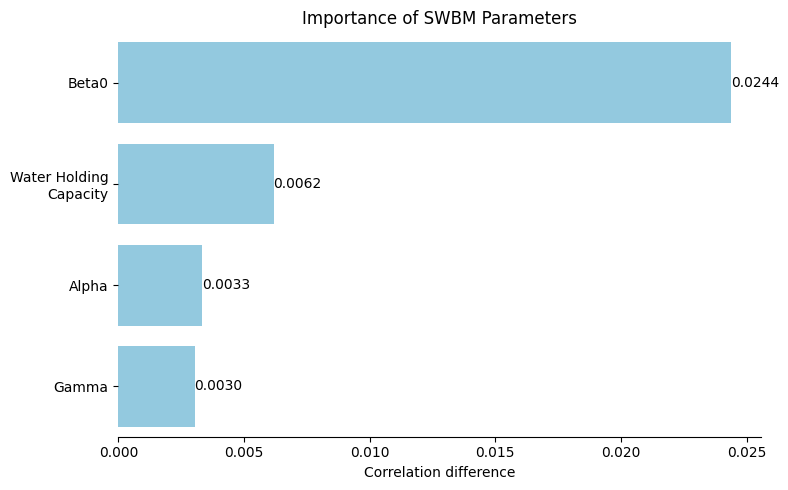

In [11]:
# plot parameter importance
plt.figure(figsize=(8, 5))
plot_param_importance(feature_importances)

# Model Comparison

### Average scores
Average of the correlations for runoff, evapotranspiration and soil moisture for each model.

/Users/johanna/Uni/EarthSysModelling/VegSWBM/src/plots.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=eval_df_avg_sorted, x='corr', y='parameter_label',


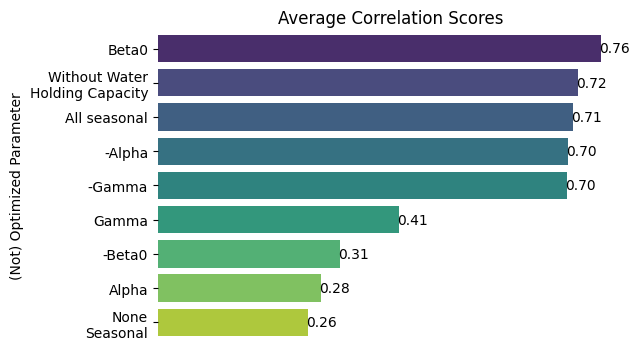

In [20]:
# average across sm, ro and et correlation and plot scores
plt.figure(figsize=(6, 4))
plot_avg_scores(eval_df)

### All correlation scores

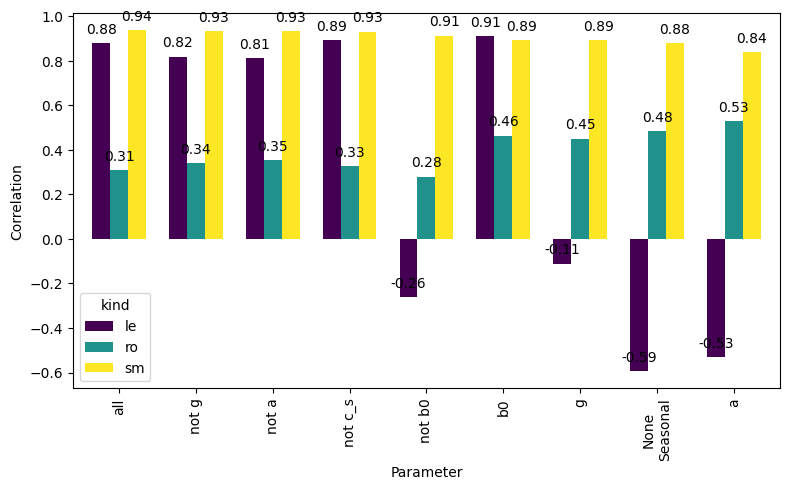

In [13]:
# Plot single opt results
pivot_df = eval_df.pivot(index='parameter', columns='kind',
                         values='corr')
pivot_df = pivot_df.sort_values(by='sm', ascending=False)

ax = pivot_df.plot(kind='bar', width=0.7, figsize=(8, 5), colormap='viridis')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points')
# Adding labels and title
ax.set_xlabel('Parameter')
ax.set_ylabel('Correlation')

# Show the plot
plt.tight_layout()
plt.show()

### Runoff is getting worse

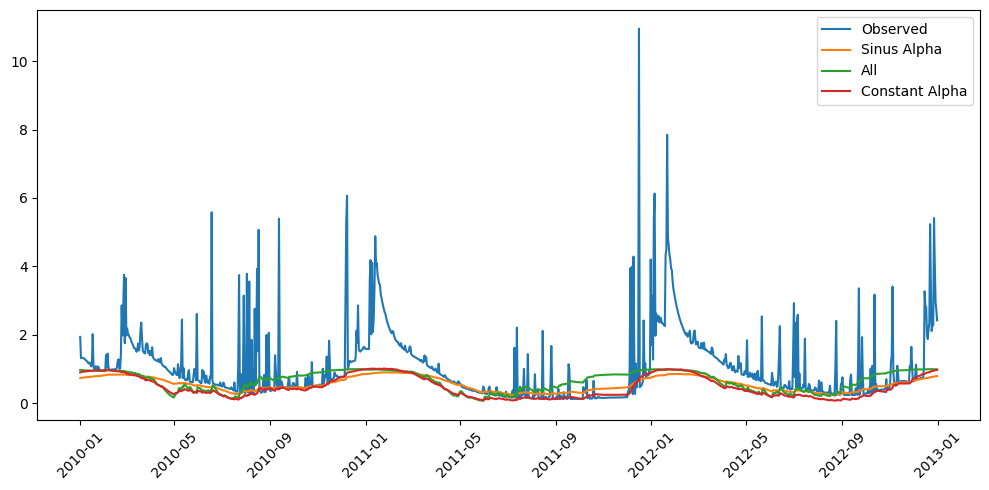

In [14]:
# whats wrong with runoff
year_mask = [date.year == 2010 or date.year == 2011 or
             date.year == 2012 for date in input_swbm['time']]

plt.figure(figsize=(10, 5))
plt.plot(input_swbm['time'][year_mask], input_swbm['ro'][year_mask],
         label='Observed')
plt.plot(input_swbm['time'][year_mask], single_preds['a']['ro'][year_mask],
         label='Sinus Alpha')
plt.plot(input_swbm['time'][year_mask], preds_all[1][year_mask],
         label='All')
plt.plot(input_swbm['time'][year_mask], runoffs[year_mask],
         label='Constant Alpha')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Final Model

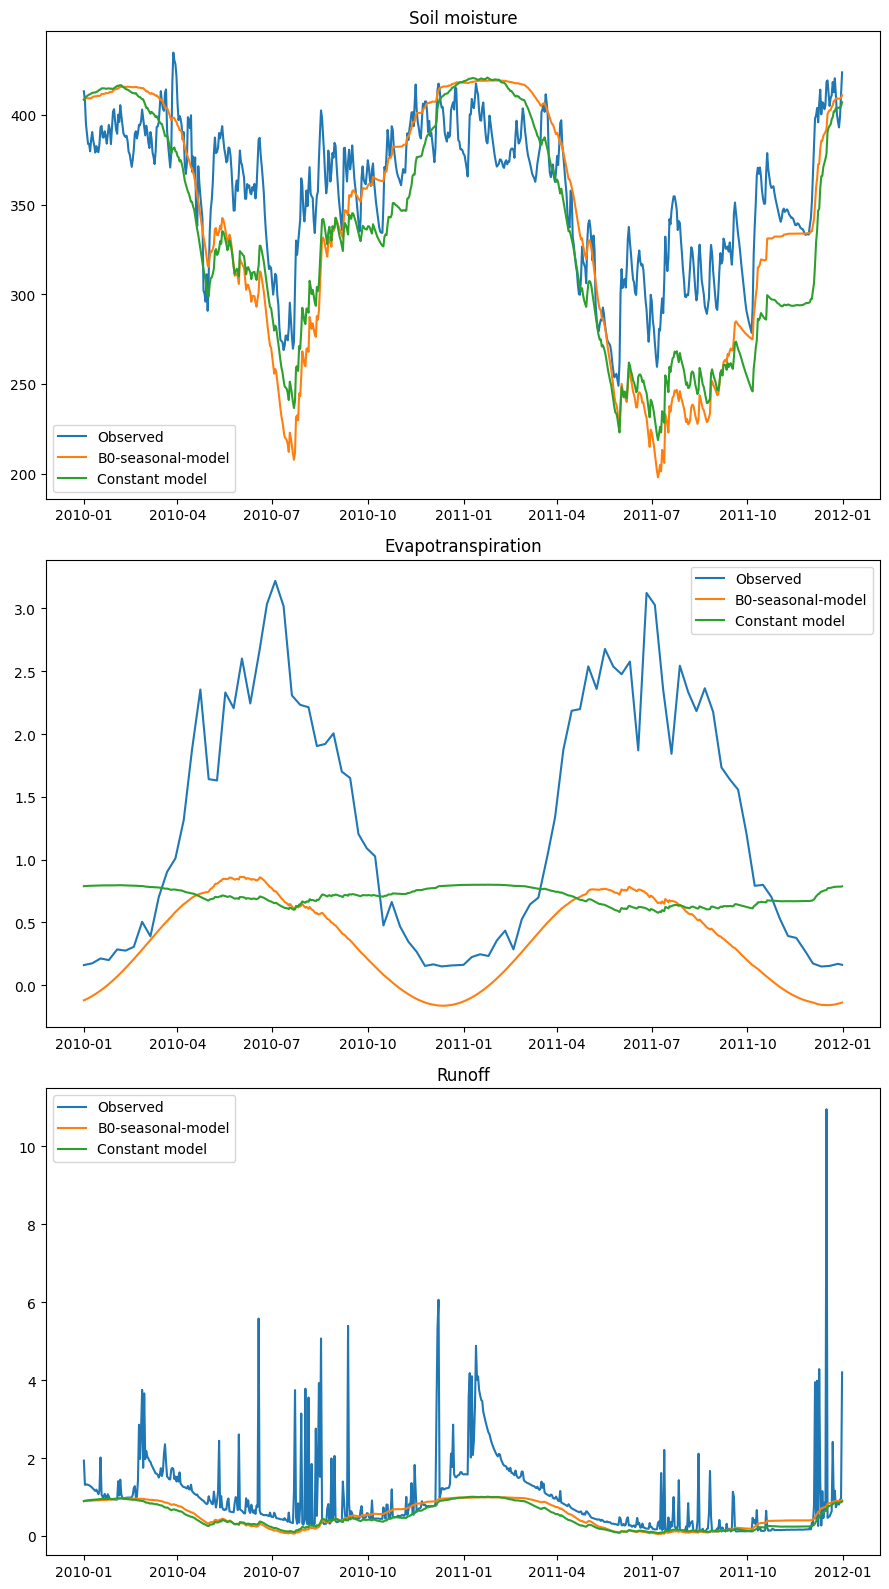

In [15]:
# visualize b0-model vs. constant-model vs. observed
year_mask = [date.year == 2010 or date.year == 2011
             for date in input_swbm['time']]
x_ticks = input_swbm['time'][year_mask]

fig, ax = plt.subplots(nrows=3, figsize=(9, 16))

ax[0].plot(x_ticks, input_swbm['sm'][year_mask] * 1000,
           label='Observed')
ax[0].plot(x_ticks, single_preds['b0']['sm'][year_mask],
           label='B0-seasonal-model')
ax[0].plot(x_ticks, moists[year_mask],
           label='Constant model')
ax[0].set_title('Soil moisture')
ax[0].legend()

ax[1].plot(x_ticks, input_swbm['le'][year_mask],
           label='Observed')
ax[1].plot(x_ticks, single_preds['b0']['le'][year_mask],
           label='B0-seasonal-model')
ax[1].plot(x_ticks, ets[year_mask],
           label='Constant model')
ax[1].set_title('Evapotranspiration')
ax[1].legend()

ax[2].plot(x_ticks, input_swbm['ro'][year_mask],
           label='Observed')
ax[2].plot(x_ticks,
           single_preds['b0']['ro'][year_mask],
           label='B0-seasonal-model')
ax[2].plot(x_ticks, runoffs[year_mask],
           label='Constant model')
ax[2].set_title('Runoff')
ax[2].legend()

plt.tight_layout()
plt.show()

## Seasonal curve of B0

In [16]:
np.round(pd.DataFrame(opt_params_dfs['b0'], index=[0]), 4)

,amplitude,freq,phase,center
0,0.816,1.9886,5.1495,0.5864


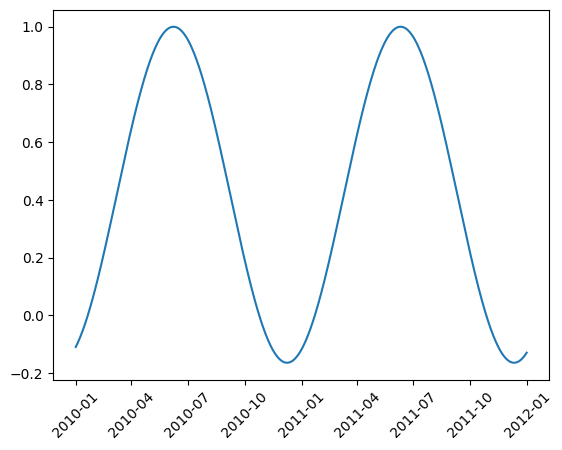

In [17]:
seasonal_b0 = seasonal_sinus(len(x_ticks),
                             amplitude=opt_params_dfs['b0']['amplitude'],
                             freq=opt_params_dfs['b0']['freq'],
                             phase=opt_params_dfs['b0']['phase'],
                             center=opt_params_dfs['b0']['center'], which='b0')
# plot our sinus for B0
plt.plot(x_ticks, seasonal_b0)
plt.xticks(rotation=45)
plt.show()

## One year time series

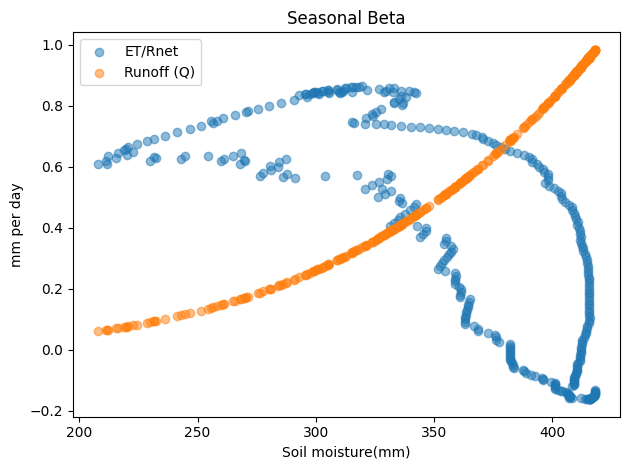

In [21]:
year_mask = [date.year == 2010 for date in input_swbm['time']]

fig, ax = plt.subplots()
ax.set_title('Seasonal Beta')
ax.scatter(single_preds['b0']['sm'][year_mask],
           single_preds['b0']['le'][year_mask], label='ET/Rnet', alpha=0.5)
ax.scatter(single_preds['b0']['sm'][year_mask],
           single_preds['b0']['ro'][year_mask], label='Runoff (Q)', alpha=0.5)
ax.set_xlabel('Soil moisture(mm)')
ax.set_ylabel('mm per day')
plt.legend()
plt.tight_layout()

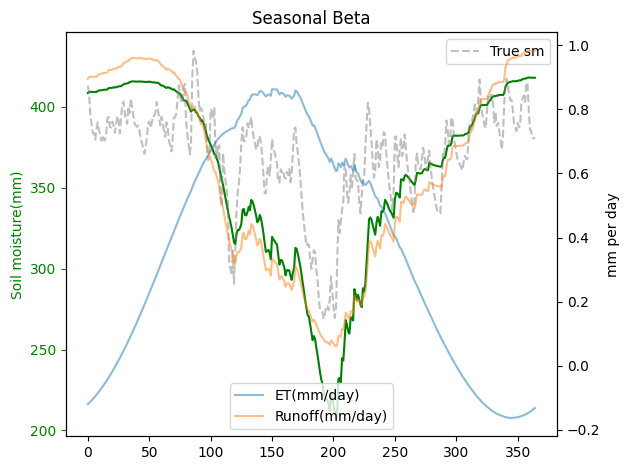

In [19]:
fig, ax = plt.subplots()
ax.set_title('Seasonal Beta')
ax, ax2 = plot_time_series(single_preds['b0']['sm'][year_mask],
                           single_preds['b0']['le'][year_mask],
                           single_preds['b0']['ro'][year_mask], ax)
ax.plot(range(365), input_swbm['sm'][year_mask] * 1000, label='True sm',
        linestyle='dashed', color='grey', alpha=0.5)
ax.set_ylabel('Soil moisture(mm)')
ax.legend()
ax2.legend()
plt.tight_layout()

# What we tried 

- Inluding score of ro and et in oprimization e.g. maximizing $0.5 * corr_{sm} + 0.25 * corr_{ro} + 0.25 * corr_{et}$
    - this improved et to up to 0.95 and ro to about 0.49 but did in any case (different weights) slightly decrease sm
- Using different solvers (optimizers) available for scipy's minimze function, but did not change or improve the outcome
